<a href="https://colab.research.google.com/github/evk905/Play_guess_int/blob/main/Project_4_ML_%D0%9A%D0%BE%D0%B2%D0%B0%D0%BB%D0%B5%D0%BD%D0%BA%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing  import LabelEncoder, MinMaxScaler,  StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, IsolationForest

import warnings
warnings.filterwarnings('ignore')


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [4]:
path = '/content/drive/MyDrive/data/bank_fin.csv'

In [5]:
df = pd.read_csv(path, sep = ';')

In [6]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,25
housing,0
loan,0
contact,0
day,0


### Задание 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

,count
job,
management,2566
blue-collar,1944
technician,1823
admin.,1334
services,923
retired,778
self-employed,405
student,360
unemployed,357


### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Функция для конвертации строки в float
def clean_balance(balance):
    if isinstance(balance, str):  # Проверяем, является ли balance строкой
        # Убираем знак валюты и пробелы, заменяем запятую на точку
        balance = balance.replace(' $', '').replace(' ', '').replace(',', '.')
        return float(balance)
    return balance  # Если это не строка, просто возвращаем значение

# Применяем функцию к столбцу balance
df['balance'] = df['balance'].apply(clean_balance)

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
# Вот так мы вычисляем медиану, игнорируя NaN значения
median_value = df['balance'].median()

# Заменяем пропуски медианным значением
df['balance'].fillna(median_value, inplace=True)

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
# Определяем модальное значение в столбце job
mode_job = df['job'].mode()[0]  # mode() возвращает Series, берем первое значение

# Заменяем строки со значением "unknown" модальным значением
df['job'].replace('unknown', mode_job, inplace=True)

# Определяем модальное значение в столбце job
mode_education = df['education'].mode()[0]  # mode() возвращает Series, берем первое значение

# Заменяем строки со значением "unknown" модальным значением
df['education'].replace('unknown', mode_education, inplace=True)

### Задание 6

In [12]:
# удалите все выбросы для признака balance
# ваш код
# Вычисляем квартильные значения
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтрация выбросов
filtered_df_outliers = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# Вывод границ и отфильтрованного DataFrame
print(f" Нижняя граница: {lower_bound}")
print(f" Верхняя граница: {upper_bound}")


 Нижняя граница: -2241.0
 Верхняя граница: 4063.0


## Часть 2:  Разведывательный анализ

### Задание 1

Частоты по классам:
deposit
no     5424
yes    4681
Name: count, dtype: int64


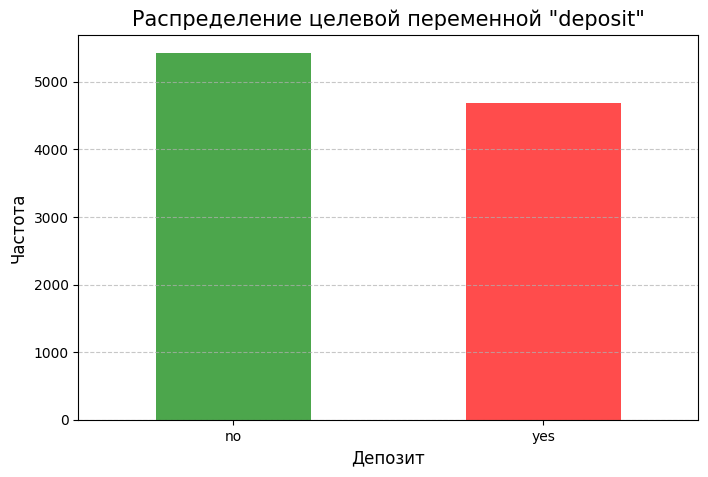

In [13]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
# Вычисляем частоты
frequency = filtered_df_outliers['deposit'].value_counts()

# Выводим частоты
print("Частоты по классам:")
print(frequency)

# Создаем диаграмму
plt.figure(figsize=(8, 5))
frequency.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Распределение целевой переменной "deposit"', fontsize=15)
plt.xlabel('Депозит', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.xticks(rotation=0)  # Убираем наклон текста на оси X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Задания 2 и 3

In [14]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
filtered_df_outliers.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [15]:
list_numeric_columns = [column for column in filtered_df_outliers.select_dtypes(include='number')]

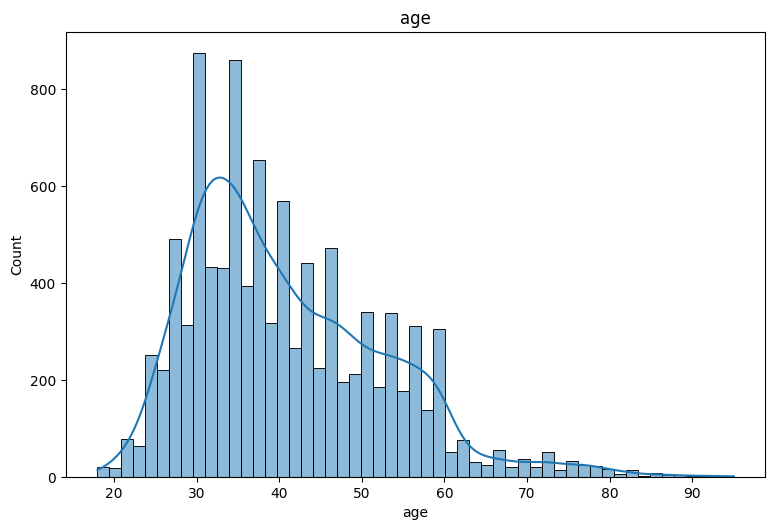

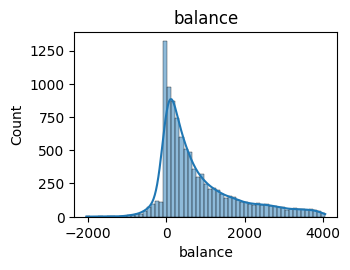

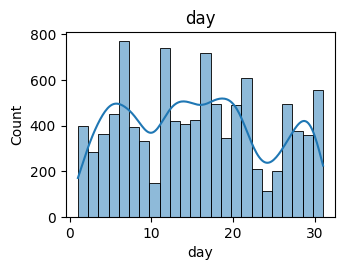

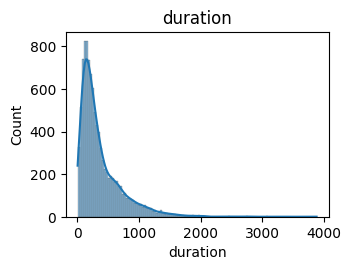

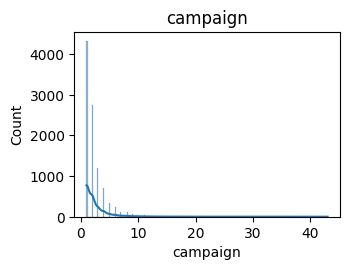

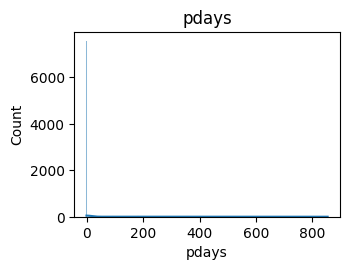

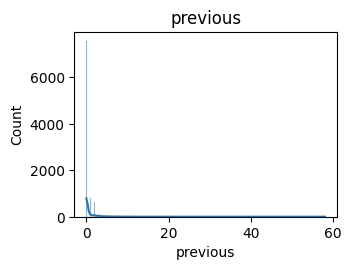

In [16]:
# Визуализация
plt.figure(figsize=(15, 10))

for column in list_numeric_columns:
  plt.subplot(2, 2, 3)
  sns.histplot(filtered_df_outliers[column], kde=True)
  plt.title(column)

  plt.tight_layout()
  plt.show()

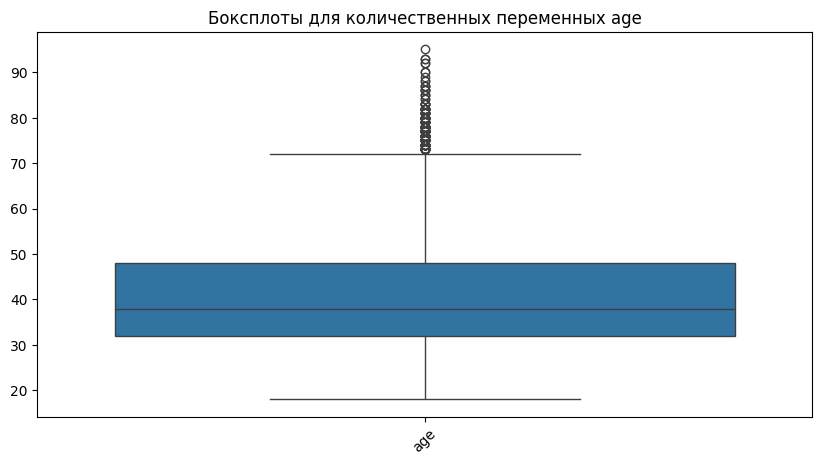

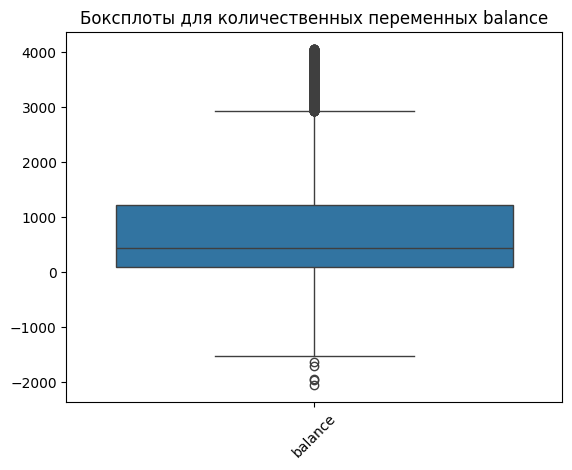

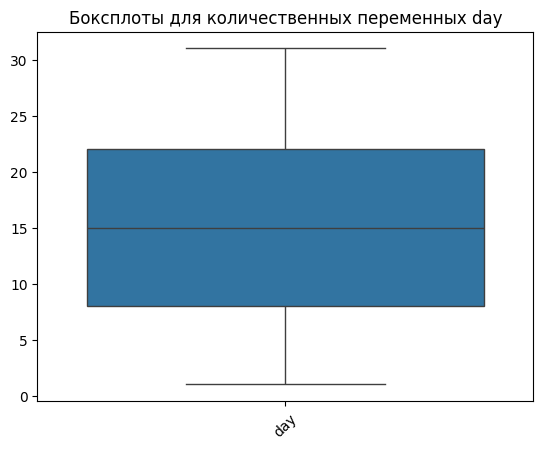

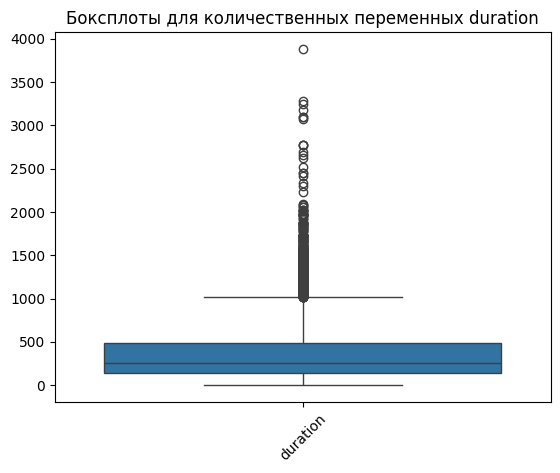

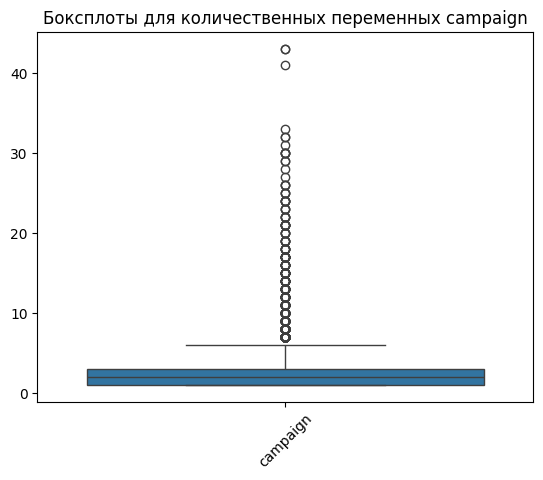

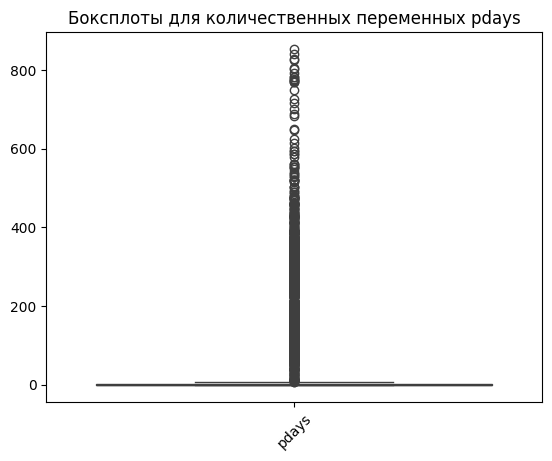

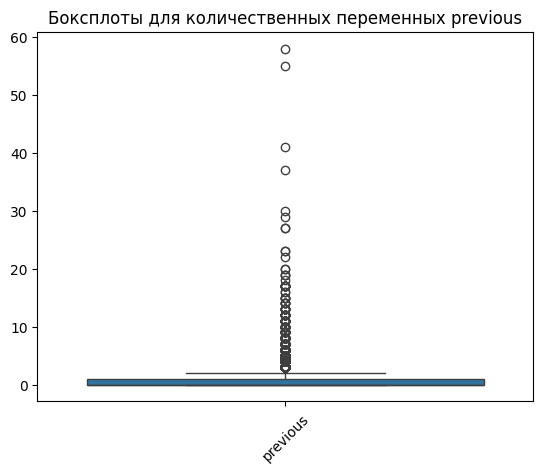

In [17]:
# Боксплоты
plt.figure(figsize=(10, 5))
for column in list_numeric_columns:
  sns.boxplot(data=filtered_df_outliers[[column]])
  plt.title(f'Боксплоты для количественных переменных {column}')
  plt.xticks(rotation=45)
  plt.show()

### Задания 4 и 5

In [18]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
list_category_columns = [column for column in filtered_df_outliers.select_dtypes(include='object')]

filtered_df_outliers.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Количество уникальных сфер занятости: 11.
Сферы занятости: ['management', 'blue-collar', 'technician', 'admin.', 'services', 'retired', 'self-employed', 'unemployed', 'student', 'entrepreneur', 'housemaid'].
Месяцы, в которые проходила кампания: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'].
Наиболее распространенное семейное положение: married (5715 случаев).
Наиболее распространенный уровень образования: secondary (5517 случаев).


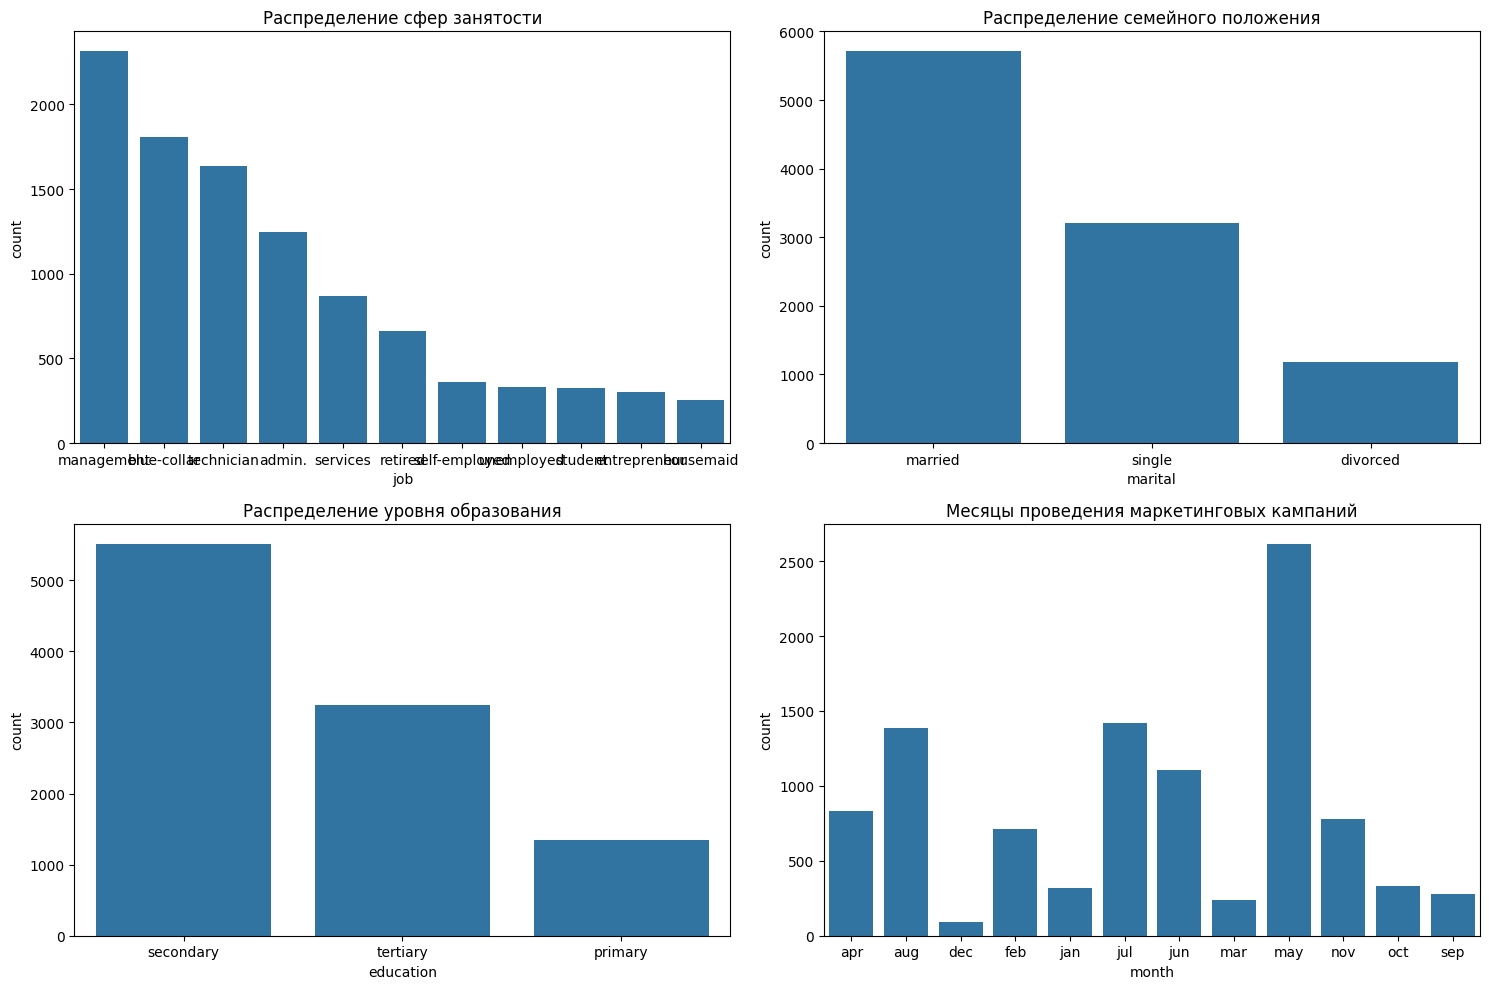

In [19]:
# Анализ категориальных переменных

# 1. Сферы занятости
job_counts = filtered_df_outliers['job'].value_counts()
num_jobs = len(job_counts)

# 2. Месяцы маркетинговых кампаний
months_present = filtered_df_outliers['month'].unique()

# 3. Семейное положение
marital_counts = filtered_df_outliers['marital'].value_counts()
most_common_marital = marital_counts.idxmax()

# 4. Уровень образования
education_counts = filtered_df_outliers['education'].value_counts()
most_common_education = education_counts.idxmax()

# Вывод результатов
print(f"Количество уникальных сфер занятости: {num_jobs}.")
print(f"Сферы занятости: {job_counts.index.tolist()}.")
print(f"Месяцы, в которые проходила кампания: {months_present}.")
print(f"Наиболее распространенное семейное положение: {most_common_marital} ({marital_counts.max()} случаев).")
print(f"Наиболее распространенный уровень образования: {most_common_education} ({education_counts.max()} случаев).")

# Визуализация результатов

plt.figure(figsize=(15, 10))

# Визуализация сферы занятости
plt.subplot(2, 2, 1)
sns.countplot(data=filtered_df_outliers, x='job', order=job_counts.index)
plt.title('Распределение сфер занятости')

# Визуализация семейного положения
plt.subplot(2, 2, 2)
sns.countplot(data=filtered_df_outliers, x='marital', order=marital_counts.index)
plt.title('Распределение семейного положения')

# Визуализация уровня образования
plt.subplot(2, 2, 3)
sns.countplot(data=filtered_df_outliers, x='education', order=education_counts.index)
plt.title('Распределение уровня образования')

# Визуализация месяцев
plt.subplot(2, 2, 4)
sns.countplot(data=filtered_df_outliers, x='month', order=sorted(months_present))
plt.title('Месяцы проведения маркетинговых кампаний')

plt.tight_layout()
plt.show()

### Задание 6

In [21]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

# Подсчёт успешных и неуспешных исходов по категориям poutcome
summary = filtered_df_outliers.groupby('poutcome')['deposit'].value_counts().unstack(fill_value=0)

# Рассчитываем общее количество успехов и неудач
summary['total_successes'] = summary.get('yes', 0)
summary['total_failures'] = summary.get('no', 0)

# Теперь мы можем проверить, для каких статусов успешные исходы превышают неудачи
summary['success_greater_than_failures'] = summary['total_successes'] > summary['total_failures']

# Выводим результаты
print(summary[['total_successes', 'total_failures', 'success_greater_than_failures']])

deposit   total_successes  total_failures  success_greater_than_failures
poutcome                                                                
failure               547             562                          False
other                 265             216                           True
success               861              84                           True
unknown              3008            4562                          False


### Задание 7

In [22]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Группируем данные по столбцу month и подсчитываем success и failure
summary_month = filtered_df_outliers.groupby(['month', 'deposit']).size().unstack(fill_value=0)
summary_month

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


<Figure size 1000x600 with 0 Axes>

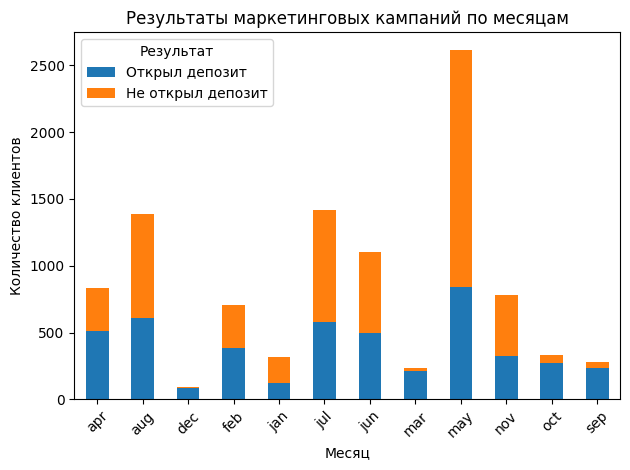

In [23]:
# Для наглядности создадим столбчатую диаграмму
plt.figure(figsize=(10, 6))
summary_month[['yes', 'no']].plot(kind='bar', stacked=True)
plt.title('Результаты маркетинговых кампаний по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.legend(title='Результат', labels=['Открыл депозит', 'Не открыл депозит'], loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Создание списка для хранения результатов
failure_rates = []

# Проходим по всем уникальным месяцам
for month in filtered_df_outliers['month'].unique():
    # Общее количество записей для данного месяца
    total = filtered_df_outliers[filtered_df_outliers['month'] == month].shape[0]
    # Количество неудач (deposit == 0) для данного месяца
    failures = filtered_df_outliers[(filtered_df_outliers['month'] == month) & (filtered_df_outliers['deposit'] == 'no')].shape[0]
    # Рассчитываем процент неудач
    failure_rate = failures / total if total > 0 else 0
    # Добавляем данные в список
    failure_rates.append({'month': month, 'failure_rate': failure_rate})

# Создаем DataFrame из списка
failure_rates_df = pd.DataFrame(failure_rates)

# Ищем месяц с самым высоким процентом неудач
max_failure = failure_rates_df.loc[failure_rates_df['failure_rate'].idxmax()]

# Выводим результаты
print(f"Месяц с самым высоким процентом неудач: {max_failure['month']}, Процент неудач: {max_failure['failure_rate']:.2%}")

Месяц с самым высоким процентом неудач: may, Процент неудач: 67.86%


### Задание 8

In [25]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Определение возрастной категории
def age_category(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'

filtered_df_outliers['age_group'] = filtered_df_outliers['age'].apply(age_category)

In [28]:
filtered_df_outliers.groupby('age_group')['deposit'].value_counts().unstack(fill_value=0)

deposit,no,yes
age_group,,
30-40,2245,1716
40-50,1444,938
50-60,984,670
60+,157,496
<30,594,861


### Задания 9 и 10

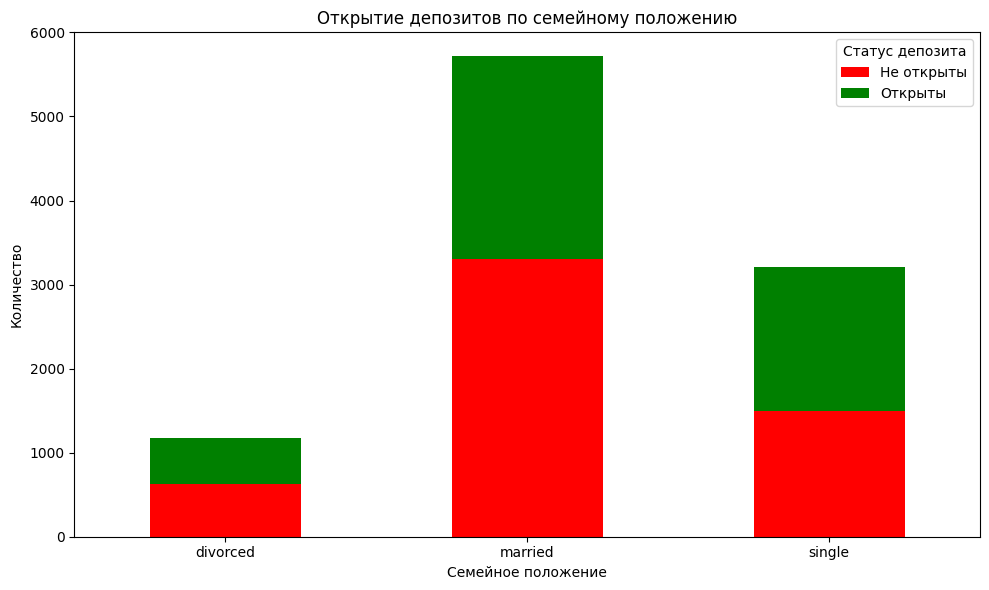

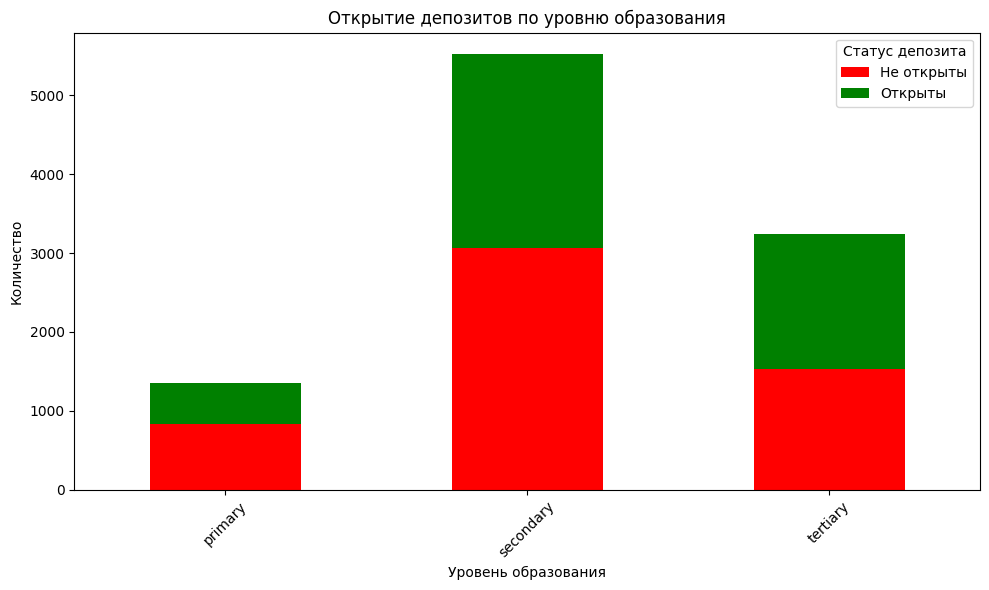

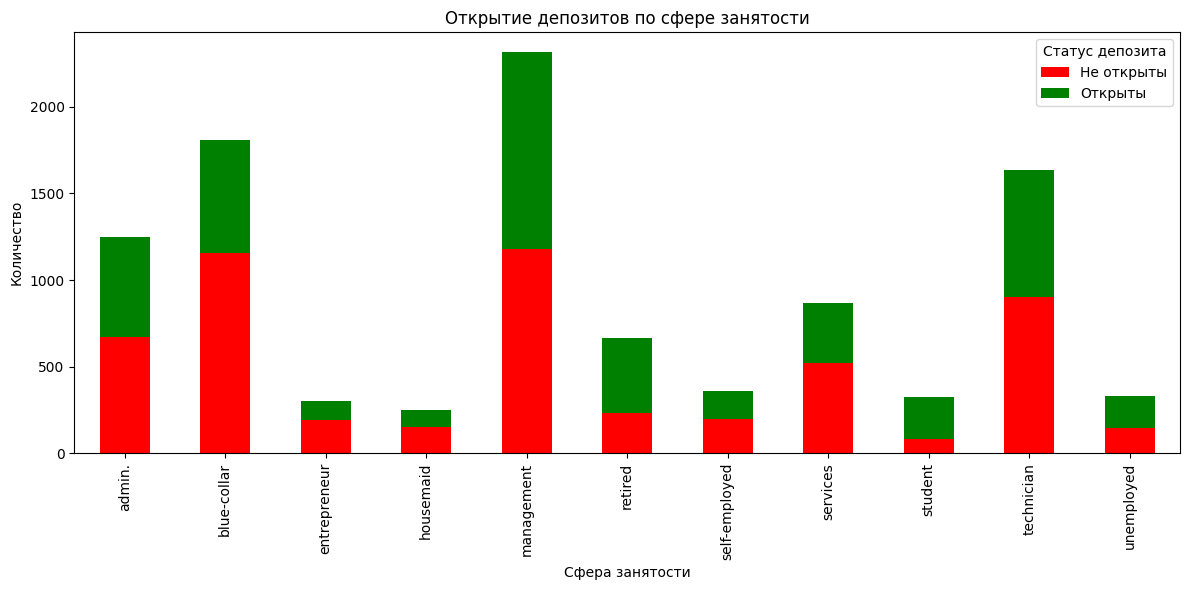

In [29]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса, от образования, от вида профессиональной занятости
# Создание сводной таблицы для marital
marital_counts = filtered_df_outliers.groupby(['marital', 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для education
education_counts = filtered_df_outliers.groupby(['education', 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для job
job_counts = filtered_df_outliers.groupby(['job', 'deposit']).size().unstack(fill_value=0)

# Визуализация семейного положения
marital_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])
plt.title('Открытие депозитов по семейному положению')
plt.xlabel('Семейное положение')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='Статус депозита', labels=['Не открыты', 'Открыты'])
plt.tight_layout()
plt.show()

# Визуализация уровня образования
education_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])
plt.title('Открытие депозитов по уровню образования')
plt.xlabel('Уровень образования')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend(title='Статус депозита', labels=['Не открыты', 'Открыты'])
plt.tight_layout()
plt.show()

# Визуализация сферы занятости
job_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Открытие депозитов по сфере занятости')
plt.xlabel('Сфера занятости')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.legend(title='Статус депозита', labels=['Не открыты', 'Открыты'])
plt.tight_layout()
plt.show()

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)


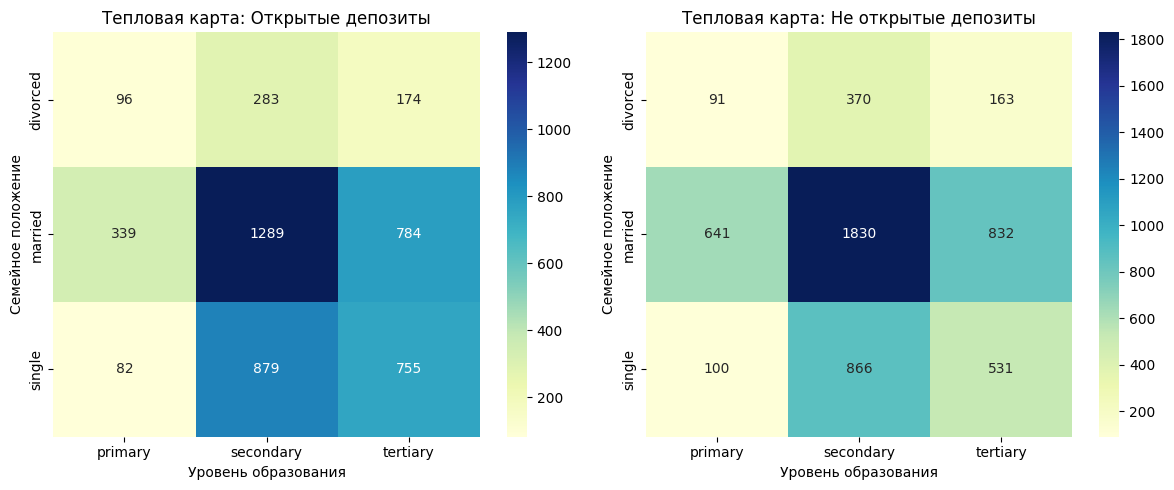

Наиболее популярная группа среди открывших депозит: married с уровнем образования secondary
Наиболее популярная группа среди не открывших депозит: married с уровнем образования secondary


In [30]:
# Разделение данных на две группы
opened_deposit = filtered_df_outliers[filtered_df_outliers['deposit'] == 'yes']
not_opened_deposit = filtered_df_outliers[filtered_df_outliers['deposit'] == 'no']

# Создание сводных таблиц
pivot_opened = pd.pivot_table(opened_deposit, index='marital', columns='education', aggfunc='size', fill_value=0)
pivot_not_opened = pd.pivot_table(not_opened_deposit, index='marital', columns='education', aggfunc='size', fill_value=0)

# Визуализация сводных таблиц в виде тепловых карт
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(pivot_opened, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Тепловая карта: Открытые депозиты')
plt.xlabel('Уровень образования')
plt.ylabel('Семейное положение')

plt.subplot(1, 2, 2)
sns.heatmap(pivot_not_opened, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Тепловая карта: Не открытые депозиты')
plt.xlabel('Уровень образования')
plt.ylabel('Семейное положение')

plt.tight_layout()
plt.show()

# Анализ результатов
# opened_max_group = pivot_opened.max().idxmax(), pivot_opened.max().name
# not_opened_max_group = pivot_not_opened.max().idxmax(), pivot_not_opened.max().name
opened_max_group = pivot_opened.stack().idxmax()
not_opened_max_group = pivot_not_opened.stack().idxmax()


print(f'Наиболее популярная группа среди открывших депозит: {opened_max_group[0]} с уровнем образования {opened_max_group[1]}')
print(f'Наиболее популярная группа среди не открывших депозит: {not_opened_max_group[0]} с уровнем образования {not_opened_max_group[1]}')

## Часть 3: преобразование данных

### Задание 1

In [31]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder

# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Применяем LabelEncoder к колонке 'education'
filtered_df_outliers['education_encoded'] = label_encoder.fit_transform(filtered_df_outliers['education'])
# Применение LabelEncoder к колонке age_group
filtered_df_outliers['age_group_encoded'] = label_encoder.fit_transform(filtered_df_outliers['age_group'])


### Задания 2 и 3

In [32]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Перекодируем значения в колонке deposit
filtered_df_outliers['deposit_encoded'] = filtered_df_outliers['deposit'].replace({'yes': 1, 'no': 0})

from sklearn.preprocessing import LabelBinarizer

# Инициализация LabelBinarizer
label_binarizer = LabelBinarizer()

# Функция для кодирования бинарных переменных
def encode_binary_variable(df, variable_name):
    encoded = label_binarizer.fit_transform(df[variable_name])
    df[f'{variable_name}_encoded'] = encoded[:, 0]

# Кодируем все бинарные переменные
binary_variables = ['default', 'housing', 'loan']
for binary_variable in binary_variables:
    encode_binary_variable(filtered_df_outliers, binary_variable)


### Задание 4

In [33]:
# создайте дамми-переменные
# Преобразование номинальных переменных в дамми-переменные
df_dummies = pd.get_dummies(filtered_df_outliers, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)

In [38]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  object 
 2   default            10105 non-null  object 
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  object 
 5   loan               10105 non-null  object 
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  object 
 12  age_group          10105 non-null  object 
 13  education_encoded  10105 non-null  int64  
 14  deposit_encoded    10105 non-null  int64  
 15  default_encoded    10105 non-null  int64  
 16  housing_encoded    10105 no

In [44]:
df_dummies['deposit_encoded'].unique()

array([1, 0])

### Задания 5 и 6

In [36]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Рассчёт матрицы корреляций только для числовых признаков

In [51]:
# Приводим столбец к числовому типу
list_columns_for_int = ['deposit_encoded', 'default_encoded', 'housing_encoded', 'loan_encoded']
for column in list_columns_for_int:
  df_dummies[column] = df_dummies[column].astype(int)

numerical_df = df_dummies.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()


In [52]:
correlation_matrix

,age,balance,day,duration,campaign,pdays,previous,education_encoded,deposit_encoded,default_encoded,housing_encoded,loan_encoded
age,1.000000,0.115164,0.000396,-0.006007,-0.001143,0.006107,0.025383,-0.191124,0.024357,-0.009929,-0.164196,-0.026357
balance,0.115164,1.000000,-0.009987,0.025781,-0.042689,0.045155,0.060419,0.043251,0.135893,-0.110928,-0.094919,-0.113089
day,0.000396,-0.009987,1.000000,-0.016695,0.142169,-0.078757,-0.059739,0.008989,-0.056878,0.018724,-0.022644,0.019136
duration,-0.006007,0.025781,-0.016695,1.000000,-0.042576,-0.033053,-0.034233,-0.016869,0.457818,-0.008162,0.038492,0.001476
campaign,-0.001143,-0.042689,0.142169,-0.042576,1.000000,-0.105214,-0.052312,-0.012280,-0.130707,0.033404,0.006257,0.033889
pdays,0.006107,0.045155,-0.078757,-0.033053,-0.105214,1.000000,0.513708,0.024123,0.147917,-0.037323,0.064138,-0.030788
previous,0.025383,0.060419,-0.059739,-0.034233,-0.052312,0.513708,1.000000,0.025368,0.141102,-0.036605,-0.000221,-0.020087
education_encoded,-0.191124,0.043251,0.008989,-0.016869,-0.012280,0.024123,0.025368,1.000000,0.098253,-0.015692,-0.094350,-0.052566
deposit_encoded,0.024357,0.135893,-0.056878,0.457818,-0.130707,0.147917,0.141102,0.098253,1.000000,-0.038872,-0.200290,-0.107240
default_encoded,-0.009929,-0.110928,0.018724,-0.008162,0.033404,-0.037323,-0.036605,-0.015692,-0.038872,1.000000,0.009551,0.074786


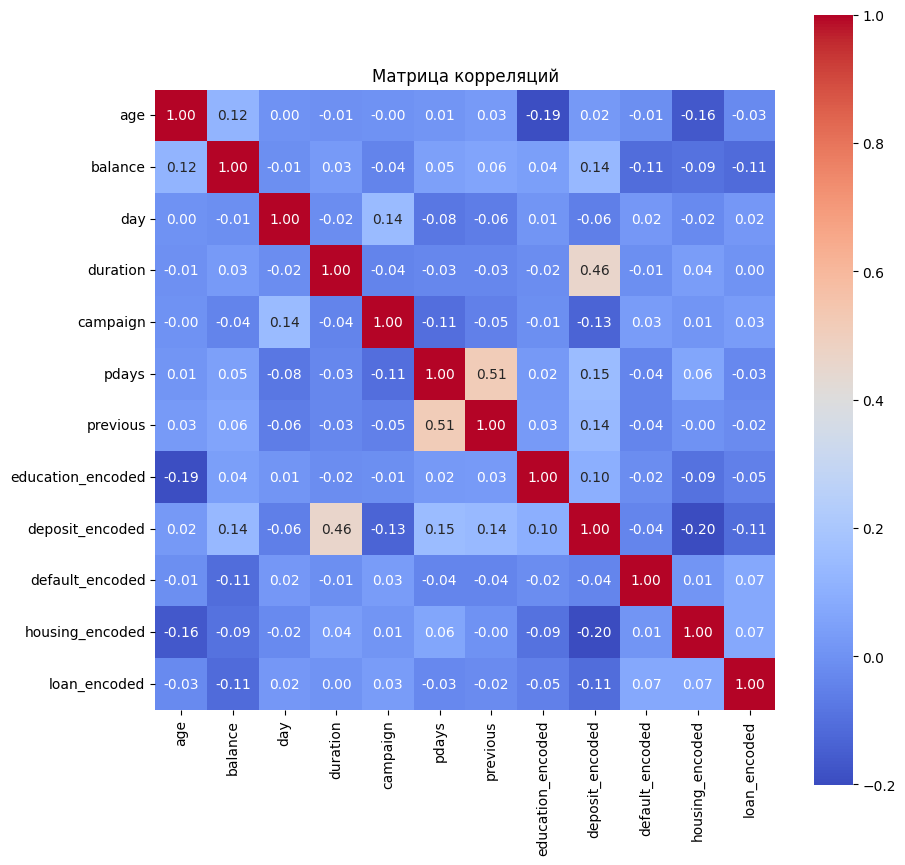

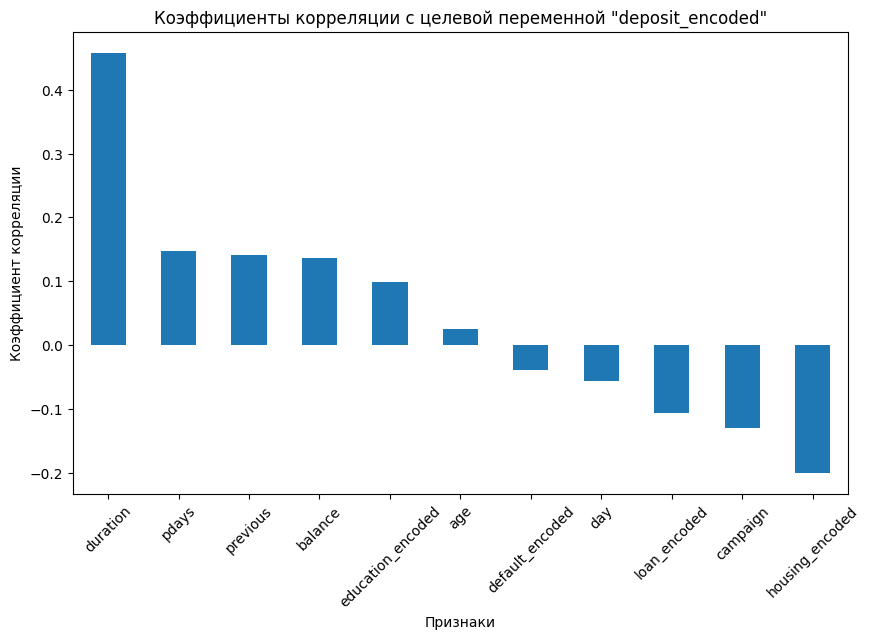

In [53]:
# Построение тепловой карты
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляций')
plt.show()

# Столбчатая диаграмма для ранжированных коэффициентов корреляции с целевой переменной
correlation_with_target = correlation_matrix['deposit_encoded'].drop('deposit_encoded').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='bar')
plt.title('Коэффициенты корреляции с целевой переменной "deposit_encoded"')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент корреляции')
plt.xticks(rotation=45)
plt.show()

### Задания 7 и 8

In [57]:
# Сначала отделим целевую переменную и оставим только числовые признаки
X = df_dummies.select_dtypes(include=['float64', 'int64']).drop(columns=['deposit_encoded'])
y = df_dummies['deposit_encoded']

# # Определяем целевую переменную и предикторы
# y = df_dummies['deposit_encoded']
# X = df_dummies.drop(columns=['deposit_encoded', 'deposit'])

# Разделяем выборку на обучающую и тестовую с заданными параметрами
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=42,
    stratify=y
)

# Выводим размеры полученных выборок
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 6770
Размер тестовой выборки: 3335


In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [58]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# Применяем SelectKBest для выбора 15 лучших признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)

# Получаем индексы отобранных признаков
selected_features_indices = selector.get_support(indices=True)

# Получаем имена отобранных признаков
selected_features = X_train.columns[selected_features_indices]

# Выводим отобранные признаки
print(f'Отобранные 15 признаков: {selected_features.tolist()}')

Отобранные 15 признаков: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'education_encoded', 'default_encoded', 'housing_encoded', 'loan_encoded']


### Задание 10

In [60]:
# Создаем объект MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем обучающую выборку
X_train_normalized = scaler.fit_transform(X_train_selected)

# Нормализуем тестовую выборку, используя параметры, полученные из обучающей выборки
X_test_selected = X_test.iloc[:, selected_features_indices]  # Выбираем только отобранные признаки
X_test_normalized = scaler.transform(X_test_selected)

# Теперь X_train_normalized и X_test_normalized содержат нормализованные данные предикторов

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [61]:
# обучите логистическую регрессию и рассчитайте метрики качества

# Создаем модель логистической регрессии
model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Обучаем модель на нормализованной обучающей выборке
model.fit(X_train_normalized, y_train)

# Делаем предсказания на нормализованной тестовой выборке
y_pred = model.predict(X_test_normalized)

# Оценим качество модели на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Выводим результаты
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.77
Confusion Matrix:
[[1476  314]
 [ 443 1102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1790
           1       0.78      0.71      0.74      1545

    accuracy                           0.77      3335
   macro avg       0.77      0.77      0.77      3335
weighted avg       0.77      0.77      0.77      3335



### Задания 2,3,4

In [62]:
# обучите решающие деревья, настройте максимальную глубину

# Создаем и настраиваем модель решающего дерева
decision_tree_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучаем модель на нормализованной обучающей выборке
decision_tree_model.fit(X_train_normalized, y_train)

# Делаем предсказания на нормализованной тестовой выборке
y_pred_tree = decision_tree_model.predict(X_test_normalized)

# Оценим качество модели на тестовой выборке
accuracy_tree = accuracy_score(y_test, y_pred_tree)
confusion_tree = confusion_matrix(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)

# Выводим результаты
print(f'Accuracy (Decision Tree): {accuracy_tree:.2f}')
print('Confusion Matrix (Decision Tree):')
print(confusion_tree)
print('Classification Report (Decision Tree):')
print(report_tree)

Accuracy (Decision Tree): 0.74
Confusion Matrix (Decision Tree):
[[1371  419]
 [ 440 1105]]
Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1790
           1       0.73      0.72      0.72      1545

    accuracy                           0.74      3335
   macro avg       0.74      0.74      0.74      3335
weighted avg       0.74      0.74      0.74      3335



Оптимальная максимальная глубина: 8
Точность на тестовой выборке при оптимальной глубине: 0.80


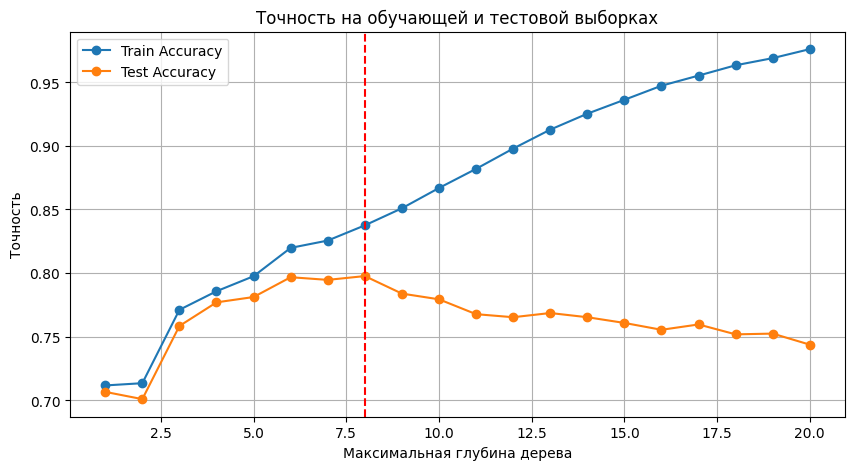

In [63]:
# Задаем диапазон максимальных глубин для перебора
max_depths = range(1, 21)  # от 1 до 20
train_accuracies = []
test_accuracies = []

# Перебираем различные максимальные глубины
for max_depth in max_depths:
    # Создаем и настраиваем модель решающего дерева с текущей глубиной
    decision_tree_model = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy', random_state=42)

    # Обучаем модель на нормализованной обучающей выборке
    decision_tree_model.fit(X_train_normalized, y_train)

    # Делаем предсказания на обучающей и тестовой выборках
    y_train_pred = decision_tree_model.predict(X_train_normalized)
    y_test_pred = decision_tree_model.predict(X_test_normalized)

    # Вычисляем точность для обучающей и тестовой выборок
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Конвертируем списки в массивы для удобства
train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)

# Находим максимальную точность на тестовой выборке и соответствующую глубину
optimal_depth_index = np.argmax(test_accuracies)
optimal_depth = max_depths[optimal_depth_index]
optimal_test_accuracy = test_accuracies[optimal_depth_index]

# Выводим результаты
print(f'Оптимальная максимальная глубина: {optimal_depth}')
print(f'Точность на тестовой выборке при оптимальной глубине: {optimal_test_accuracy:.2f}')

# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Точность')
plt.title('Точность на обучающей и тестовой выборках')
plt.legend()
plt.grid()
plt.axvline(optimal_depth, color='red', linestyle='--', label='Оптимальная глубина')
plt.show()

### Задание 5

In [64]:
# подберите оптимальные параметры с помощью gridsearch

# Задаем параметры для GridSearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,  # 5-кратная кросс-валидация
                           n_jobs=-1)  # Используем все доступные процессоры

# Обучаем модель
grid_search.fit(X_train_normalized, y_train)

# Получаем лучшие параметры и результат
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Оцениваем модель на тестовой выборке
best_model = grid_search.best_estimator_
# Предсказание на тестовой выборке
y_test_pred = best_model.predict(X_test_normalized)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Выводим результаты
print(f'Лучшие параметры: {best_params}')
print(f'Точность на обучающей выборке (кросс-валидация): {best_accuracy:.2f}')
print(f'Точность на тестовой выборке: {test_accuracy:.2f}')

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 2}
Точность на обучающей выборке (кросс-валидация): 0.80
Точность на тестовой выборке: 0.79


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [67]:
# обучите на ваших данных случайный лес

#  Обучение модели случайного леса
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
rf_model.fit(X_train_normalized, y_train)

#  Прогнозирование на тестовой выборке
y_pred_rf = rf_model.predict(X_test_normalized)

#  Оценка точности модели
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy of the random forest model: {accuracy:.2f}')
f1 = f1_score(y_test, y_pred_rf, average='binary')
print(f'F1 of the random forest model: {f1:.2f}')

Accuracy of the random forest model: 0.81
F1 of the random forest model: 0.80


### Задания 2 и 3

In [66]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Создание модели градиентного бустинга
model = GradientBoostingClassifier(learning_rate=0.05,
                                    n_estimators=300,
                                    min_samples_leaf=5,
                                    max_depth=5,
                                    random_state=42)

# Обучение модели
model.fit(X_train_normalized, y_train)

# Предсказание на тестовой выборке
y_pred_gd = model.predict(X_test_normalized)

# Оценка F1-метрики
f1 = f1_score(y_test, y_pred_gd, average='binary')  # Установите average='macro' для многоклассовой классификации
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.80


### Задание 4

In [68]:
# объедините уже известные вам алгоритмы с помощью стекинга

# Создаем базовые модели для стекинга
base_estimators = [
    ('decision_tree', DecisionTreeClassifier(criterion='entropy', random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))
]

# Метамодель, которая будет обучаться на предсказаниях базовых моделей
meta_model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Создание стека моделей с помощью StackingClassifier
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=meta_model, cv=5)

# Обучаем стековую модель на нормализованных обучающих данных
stacking_model.fit(X_train_normalized, y_train)

# Получаем предсказания на тестовой выборке
y_pred = stacking_model.predict(X_test_normalized)

# Вычисляем и выводим метрику precision для оценивания качества модели
precision = precision_score(y_test, y_pred)
print(f'Precision на тестовой выборке: {precision:.4f}')

Precision на тестовой выборке: 0.7951


In [69]:
#Оценка F1-метрики
f1 = f1_score(y_test, y_pred, average='binary')  # Установите average='macro' для многоклассовой классификации
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.80


### Задание 5

In [70]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга


# Теперь можно перейти к обучению моделей, например, Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_normalized, y_train)  # Обучение модели

# Если вы хотите обучить другие модели, можно использовать аналогичный подход
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_normalized, y_train)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_normalized, y_train)

gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train_normalized, y_train)

# Можно также оценить производительность моделей на тестовой выборке
# Для этого необходимо использовать методы оценки, такие как accuracy_score
from sklearn.metrics import accuracy_score

# Оценка логистической регрессии
y_pred_logistic = logistic_model.predict(X_test_normalized)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

# Выводим точность модели
print(f'Точность логистической регрессии: {accuracy_logistic:.2f}')

# Аналогично можно оценить другие модели
y_pred_decision_tree = decision_tree_model.predict(X_test_normalized)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)

print(f'Точность дерева решений: {accuracy_decision_tree:.2f}')

y_pred_random_forest = random_forest_model.predict(X_test_normalized)
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)

print(f'Точность случайного леса: {accuracy_random_forest:.2f}')

y_pred_gradient_boosting = gradient_boosting_model.predict(X_test_normalized)
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)

print(f'Точность градиентного бустинга: {accuracy_gradient_boosting:.2f}')

Точность логистической регрессии: 0.77
Точность дерева решений: 0.74
Точность случайного леса: 0.81
Точность градиентного бустинга: 0.81


Три наиболее важных признака и их важность:
duration: 0.4177
balance: 0.1248
age: 0.1237
day: 0.0982
pdays: 0.0623


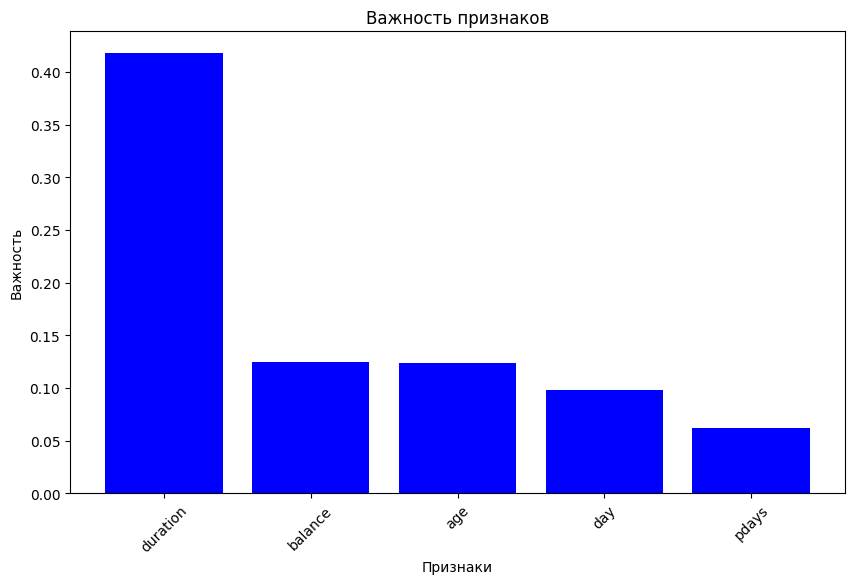

In [71]:
# Создаем объект RandomForestClassifier и обучаем модель на выбранных признаках
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train)

# Получаем важность признаков
importances = rf_model.feature_importances_

# Индексы признаков в порядке убывания важности
indices = np.argsort(importances)[::-1]

# Извлекаем три наиболее важных признака
top_feature_indices = indices[:5]
top_features = selected_features[top_feature_indices]
top_importances = importances[top_feature_indices]

# Выводим три наиболее важных признака
print("Три наиболее важных признака и их важность:")
for i in range(5):
    print(f"{top_features[i]}: {top_importances[i]:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.bar(range(5), top_importances, color='b', align='center')
plt.xticks(range(5), top_features, rotation=45)
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.show()

### Задания 6,7,8

In [72]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.4 MB/s eta 0:00:00


In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna

In [74]:
# Функция цели для оптимизации гиперпараметров с помощью Optuna
def objective(trial):
    # Определяем гиперпараметры для модели RandomForestClassifier
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем и обучаем модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train_normalized, y_train)

    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test_normalized)

    # Оценка качества модели
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Создаем объект исследования Optuna
study = optuna.create_study(direction='maximize')

# Запускаем оптимизацию
study.optimize(objective, n_trials=100)

# Выводим результаты
print("Лучшие параметры:")
print(study.best_params)
print("Лучшее значение accuracy:")
print(study.best_value)

[I 2025-06-05 12:39:41,444] A new study created in memory with name: no-name-2d716957-544c-41c0-9534-526745a2392e
[I 2025-06-05 12:39:46,123] Trial 0 finished with value: 0.8122938530734632 and parameters: {'n_estimators': 126, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8122938530734632.
[I 2025-06-05 12:39:50,362] Trial 1 finished with value: 0.8143928035982009 and parameters: {'n_estimators': 194, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8143928035982009.
[I 2025-06-05 12:39:52,532] Trial 2 finished with value: 0.8146926536731635 and parameters: {'n_estimators': 119, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8146926536731635.
[I 2025-06-05 12:39:54,351] Trial 3 finished with value: 0.8134932533733134 and parameters: {'n_estimators': 157, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8146926536731635.
[I 2025-06-05 12:39:55,456] Trial 4 finished with value: 0.813493253373313

Лучшие параметры:
{'n_estimators': 175, 'max_depth': 20, 'min_samples_leaf': 8}
Лучшее значение accuracy:
0.8170914542728636
